## Multi-channel source separation using projected gradient and Frobenius cost function

TODO
* **check l'estimation de A sur un melange synthetique**
* utiliser une autre fonction de cout (IS, KL)
* faire varier init sigma_b
* check nombre d'appel au calcul de cost/gradient par iteration/total
* essayer avec le gradient stochastique/injection d'un bruit alpha stable

In [1]:
import numpy as np
import soundfile
import time
import resampy
import sys
import os
import os.path
from STFT import *
from pg_fro import FroMnmfOptim

In [2]:
# initialisation mixing matrix
from init_inst_mixing_matrix import estmix_inst  

In [3]:
audio_dir = '../audio/CM'
filename_16k = 'Christophe_Mae_La_Parisienne_cut16k.wav'

read audio file

In [4]:
x, sr = soundfile.read(os.path.join(audio_dir, filename_16k))
xlen, n_channels = x.shape
# add small noise to avoid numerical problems
xsmallcst = 1e-10
x += xsmallcst*np.random.randn(xlen, n_channels)

short term Fourier transform

In [5]:
wlen_sec = 0.060  # size of the analysis window in seconds
window_size = int(np.round(wlen_sec*sr))
hop_size = window_size//2
print('window length in samples %d, hop size %d' % (window_size, hop_size))

nfft = 1
while nfft < window_size:
    nfft *= 2
print('fft window size %d' % nfft)

# multi-channel STFT
for ch in range(n_channels):
    xx, _, _ = Stft(x[:, ch], window_size, hop_size, nfft, sr)
    if ch == 0:
        F, N = xx.shape
        X = np.zeros((F, N, n_channels), dtype=np.complex64)
    X[:, :, ch] = xx
print(X.shape)

window length in samples 960, hop size 480
fft window size 1024
(513, 268, 2)


/Users/benaroya/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [6]:
J = 3
n_sources = J
print("number of sources: %d" % J)

number of sources: 3


Mixing matrix using one of the following
* P. Bofil's algorithm
* random initialisation
* user guess

In [7]:
# np.random.seed(1)
estimate_mixing_mat = False
if estimate_mixing_mat:
    A_est = estmix_inst(X, J)
    A_init = A_est
    print('Mixing matrix estimate')
else:
    A_rand = np.random.rand(2,J)
    A_init = A_rand/A_rand[0, :]
    print('Random init mixing matrix')
A_init = np.ones((2, J))
A_init[1, :] = [0.5, 1., 1.2]
print(A_init)    

Random init mixing matrix
[[1.  1.  1. ]
 [0.5 1.  1.2]]


In [8]:
# set seed
np.random.seed(1)
# initialize W and H
wh_min_val = 1e-8

n_comp = [15, 30, 15]  # np.array([20, 20, 10, 4])
print('nmf components per source')
print(n_comp)
if isinstance(n_comp, int):
    n_comp_tot = J*n_comp
else:
    n_comp_tot = np.sum(n_comp)

W_init = np.random.rand(F, n_comp_tot) + wh_min_val
H_init = np.random.rand(n_comp_tot, N) + wh_min_val
# print('total number of nmf components: %d' %n_comp_tot)
print(W_init.shape)
print(H_init.shape)

nmf components per source
[15, 30, 15]
(513, 60)
(60, 268)


compute empirical covariance

In [9]:
I = n_channels
CovX = np.zeros((F, N, I, I), dtype=np.complex64)

if I == 2:
    CovX[:, :, 0, 0] = np.abs(X[:, :, 0])**2
    CovX[:, :, 1, 1] = np.abs(X[:, :, 1])**2
    CovX[:, :, 1, 0] = X[:, :, 1]*X[:, :, 0].conj()
    CovX[:, :, 0, 1] = X[:, :, 0]*X[:, :, 1].conj()

else:
    for f in range(F):
        for n in range(N):
            CovX[f, n, :, :] += np.outer(X[f, n, :], X[f, n, :].conj())

intialize noise variance

In [10]:
# sigmab = np.ones((F, 1))
# sigma_b_init = 1/1000*np.mean(np.mean(np.abs(X)**2, axis=1), axis=1).reshape((-1, 1))
# plt.plot(np.log10(sigma_b_init))
# plt.show()
sigma_b_init = 1e-3

create frobenius class instance

In [11]:
W = np.copy(W_init)
H = np.copy(H_init)
A = np.copy(A_init)
sigma_b = np.copy(sigma_b_init)
#######
class_mnf_fro = FroMnmfOptim(X, A, W, H, sigma_b, num_comp=n_comp , CovX=CovX)

Block Coordinate gradient descent

In [12]:
nb_iter = 300
cost = np.zeros((nb_iter,))
tic = time.time()
for it in range(nb_iter):
    class_mnf_fro.gradentdescent('W', iter=1, dosave=True)
    class_mnf_fro.gradentdescent('H', iter=1, dosave=True)
    class_mnf_fro.gradentdescent('A', iter=1, dosave=True)
    cost[it] = class_mnf_fro.froCost(dosave=False, output=True, verbose=False)
    if (it+1) % 20 == 0:
        print('iteration %d, cost %f\r' % ((it+1), cost[it]/1000000), end="")
elapsed_time = time.time() - tic
print('Total Elapsed time: %.4f' % elapsed_time)

/Users/benaroya/Documents/python/multichannel-NMF/pg_fro.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, :, j])
/Users/benaroya/Documents/python/multichannel-NMF/pg_fro.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:, :, j])


Total Elapsed time: 995.115321


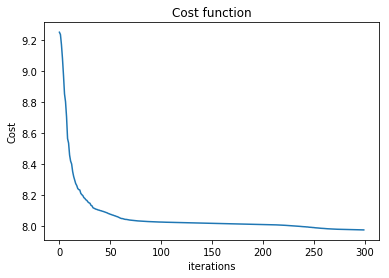

In [13]:
plt.plot(np.log10(cost))
plt.title('Cost function')
plt.xlabel('iterations')
plt.ylabel('Cost')
plt.show()

In [14]:
print(n_comp)
print(W.shape)
print(H.shape)

[15, 30, 15]
(513, 60)
(60, 268)


In [15]:
print('Mixing matrix final estimate')
# normalized mixing matrix
A_pg = class_mnf_fro._A
print(A_pg/A_pg[0,:])

Mixing matrix final estimate
[[1.         1.         1.        ]
 [0.63349226 1.02638863 1.01858612]]


Source estimation

In [16]:
class_mnf_fro.WienerFilter(output_stereo=True)

plot and save sources

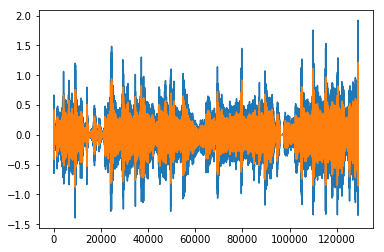

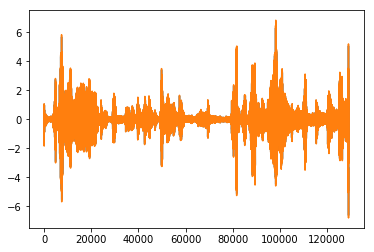

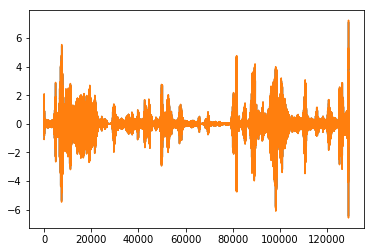

In [17]:
for j in range(J):
    # inverse STFT
    # s_j, _ = Istft(class_mnf_fro._sources[:, :, j], window_size, hop_size, nfft, sr)

    s_j_0, _ = Istft(class_mnf_fro._sources[:, :, 0, j], window_size, hop_size, nfft, sr)
    s_j_1, _ = Istft(class_mnf_fro._sources[:, :, 1, j], window_size, hop_size, nfft, sr)
    s_j = np.vstack((s_j_0, s_j_1)).T
    plt.plot(s_j)
    plt.show()
    # normalize
    s_j /= np.max(np.abs(s_j)) + 1e-8
    # save audio
    outputFile = os.path.join(audio_dir, 'output' , 'source' + str(j) + '.wav')
    soundfile.write(outputFile, s_j, sr)

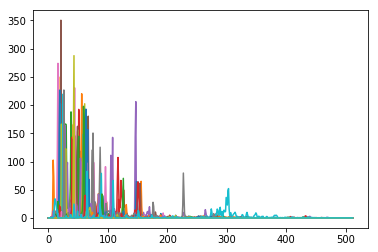

In [18]:
# plt.plot(np.log10(class_mnf_fro._W))
plt.plot(class_mnf_fro._W)
plt.show()

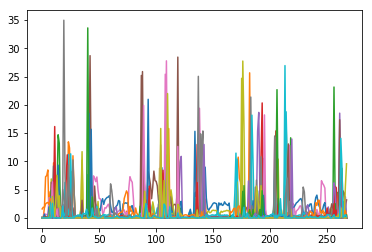

In [19]:
plt.plot(class_mnf_fro._H.T)
plt.show()